## Header

In [1]:
from esnb import CaseGroup2, NotebookDiagnostic, RequestedVariable
from esnb.sites.gfdl import call_dmget

mode = "prod"

# Verbosity
verbose = True

# Give your diagnostic a name and a short description
diag_name = "surface water mass transformation analysis"
diag_desc = "this is water mass transformation analysis using xwmt-new"

# Define what variables you would like to analyze. The first entry is the
# variable name and the second entry is the realm (post-processing dir).
#   (By default, monthly timeseries data will be loaded. TODO: add documentation
#    on how to select different frequencies, multiple realms to search, etc.)
variables = [
    RequestedVariable("tos", "ocean_monthly"),
    RequestedVariable("sos", "ocean_monthly"),
]

# Optional: define runtime settings or options for your diagnostic
user_options = {"N/A": ["N/A"]}

# Initialize the diagnostic with its name, description, vars, and options
diag = NotebookDiagnostic(diag_name, diag_desc, variables=variables, **user_options)

# Define the groups of experiments to analyze. Provide a single dora id for one experiment
# or a list of IDs to aggregate multiple experiments into one; e.g. historical+future runs
groups = [
    CaseGroup2("odiv-1", date_range=("0200-01-01", "0250-12-31")),
    CaseGroup2("odiv-3", date_range=("0060-01-01", "0090-12-31")),
    #CaseGroup2("895", date_range=("0200-01-01", "0230-12-31")),
    #CaseGroup2("2198", date_range=("0200-01-01", "0230-12-31")),
    #CaseGroup2("2916", date_range=("0200-01-01", "0230-12-31")),
    #CaseGroup2("3015", date_range=("0200-01-01", "0230-12-31")),
    #CaseGroup2("odiv-3", date_range=("0001-01-01", "0003-12-31")),
    #CaseGroup2("895", date_range=("0200-01-01", "0205-12-31")),
    #CaseGroup2("2198", date_range=("0200-01-01", "0205-12-31")),
    #CaseGroup2("2916", date_range=("0200-01-01", "0205-12-31")),
    #CaseGroup2("3015", date_range=("0200-01-01", "0205-12-31")),
]


/nbhome/ogrp/python/envs/py312_20250611/lib/python3.12/site-packages/momlevel/tidegauge.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkgr


In [2]:
diag.resolve(groups)

def diag_get():
    """
    helper function to dmget to get dsets of above vars/files
    """
    call_dmget(diag.files)
    diag.open()
diag_get()

dmget: All files are online


## Imports

In [3]:
import xwmt # This is xwmt-new
import numpy as np
import os
import cftime
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import momgrid as mg
from momgrid.geoslice import geoslice
import os as os
import cartopy.crs as ccrs
import gsw  # TEOS-10
import xbudget
import xgcm
from cmip_basins.basins import generate_basin_codes
import copy
import cartopy.feature as cfeature
import cmocean
import pandas as pd
from matplotlib.lines import Line2D
from collections.abc import Sequence
from matplotlib.gridspec import GridSpec


os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/jpk/grid_weights" # get rid of any momgrid
variables_names = [variable.varname for variable in variables]

## Functions

In [33]:
def realm_list():
    """
    returns dsets[i][j], s.t. i is the case experiment with all variables, and j is the realm
    """
    diag_get()
    out = []
    ice_var = next((v for v in variables if v.varname == "siconc"), None)

    for g in diag.groups:
        d = g.datasets
        realms = []
        nonice = [d[v] for v in variables if v is not ice_var]
        if nonice:
            realms.append(xr.merge(nonice).sortby("time").dropna(dim="time", how="all"))

        if ice_var:
            realms.append(d[ice_var])

        out.append(realms)

    return out


def groupCoordinateChange(raw_dsets, groups, basin_integer=None):
    """
    Given some case groups list as groups, performs appropriate
    remappings of variable names to be compatible to xwmt python package
    maps:
        xh->x
        yh->y
        geolat->lat
        geolon->lon
    inputs
    - dsets[n][i] which is indexed by n as the CaseGroup n, and i as the realm of data (i.e. ocean_month, atmos_cmip, etc.)
    - groups as list of CaseGroup objects corresponding to the
    - basin_integer
    outputs
    - dsets[n][i] as the list of lists xarray dataset experiments
    - basincodes_arr[n][i] as the list of lists basincodes (i.e. some integer for each basin)
    """
    dsets_copy = copy.deepcopy(raw_dsets)
    basincodes_arr = [[None for _ in row] for row in dsets_copy]
    coords = {
        "X": {
            "center": "x",
        },
        "Y": {
            "center": "y",
        },
    }
    metrics = {("X", "Y"): "areacello"}
    for n, group in enumerate(groups):
        for i, ds in enumerate(dsets_copy[n]):
            dsets_copy[n][i] = mg.Gridset(ds).data
            # this must be made more agnostic
            if "y" not in list(dsets_copy[n][i].coords):
                dsets_copy[n][i] = dsets_copy[n][i].rename({"yh": "y"})
            if "x" not in list(dsets_copy[n][i].coords):
                dsets_copy[n][i] = dsets_copy[n][i].rename({"xh": "x"})
            if "lat" not in list(dsets_copy[n][i].coords):
                dsets_copy[n][i] = dsets_copy[n][i].rename({"geolat": "lat"})
            if "lon" not in list(dsets_copy[n][i].coords):
                dsets_copy[n][i] = dsets_copy[n][i].rename({"geolon": "lon"})
            if basin_integer is not None:
                basincodes_arr[n][i] = generate_basin_codes(
                    dsets_copy[n][i], lon="lon", lat="lat", mask="wet"
                )
                if basin_integer > 10:
                    # if greater than 10, this mask is a custom mask, which must be created, not from cmip basins
                    basincodes_arr[n][i] = custom_basins(
                        basin_integer, basincodes_arr[n][i]
                    )
                    dsets_copy[n][i] = (
                        dsets_copy[n][i]
                        .where((basincodes_arr[n][i] == basin_integer))
                        .copy(deep=True)
                    )
                else:
                    dsets_copy[n][i] = (
                        dsets_copy[n][i]
                        .where((basincodes_arr[n][i] == basin_integer))
                        .copy(deep=True)
                    )
            dsets_copy[n][i] = xgcm.Grid(
                dsets_copy[n][i],
                coords=coords,
                metrics=metrics,
                boundary={"X": "periodic", "Y": "extend"},
                autoparse_metadata=False,
            )
    return dsets_copy, basincodes_arr


def custom_basins(basin_integer, basincodes_i):
    """
    given a basin_code integer, returns the custom basin.
    Supports N ATL (11), S ATL (12), N PAC (13), S PAC (14), Labrador Sea (15), barents sea (16)
    inputs
    - basin_integer as the integer corresponding to the basin we care about
    - basincodes_i as the basin codes array that is generated
    outputs
    - copy_arr_XXX(X) as the basin mask of interest
    """
    copy_arr = basincodes_i.copy(deep=True)
    # if atlantic if ...
    if (basin_integer == 11) or (basin_integer == 12) or (basin_integer == 15):
        copy_arr_ATL = copy_arr.where((copy_arr == 2))
        copy_arr_ATL["avg_lat"] = copy_arr_ATL.lat.mean(axis=1)
        copy_arr_ATL["avg_lon"] = copy_arr_ATL.lon.mean(axis=0)
        if (basin_integer == 11) or (basin_integer == 15):
            # just NATL basins
            copy_arr_NATL = copy_arr_ATL.where(copy_arr_ATL.avg_lat > 0, np.nan)
            copy_arr_NATL = copy_arr_NATL.where(np.isnan(copy_arr_NATL), other=11)
            if basin_integer == 11:
                return copy_arr_NATL
            elif basin_integer == 15:
                copy_arr_LAB = copy_arr_NATL.where(
                    copy_arr_ATL.avg_lat > 54, np.nan
                ).copy(deep=True)
                copy_arr_LAB = copy_arr_LAB.where(copy_arr_ATL.avg_lon < -47.5, np.nan)
                copy_arr_LAB = copy_arr_LAB.where(copy_arr_ATL.avg_lon > -67, np.nan)
                copy_arr_LAB = copy_arr_LAB.where(np.isnan(copy_arr_LAB), other=15)
                return copy_arr_LAB
        elif basin_integer == 12:
            # south atlantic basins
            copy_arr_SATL = copy_arr_ATL.where(copy_arr_ATL.avg_lat <= 0, np.nan)
            copy_arr_SATL = copy_arr_SATL.where(np.isnan(copy_arr_SATL), other=12)
            return copy_arr_SATL

    # if pacficic ...
    elif (basin_integer == 13) or (basin_integer == 14):
        copy_arr_PAC = copy_arr.where((copy_arr == 3))
        copy_arr_PAC["avg_lat"] = copy_arr_PAC.lat.mean(axis=1)
        if basin_integer == 13:
            copy_arr_NPAC = copy_arr_PAC.where(copy_arr_PAC.avg_lat > 0, np.nan)
            copy_arr_NPAC = copy_arr_NPAC.where(np.isnan(copy_arr_NPAC), other=13)
            return copy_arr_NPAC
        elif basin_integer == 14:
            copy_arr_SPAC = copy_arr_PAC.where(copy_arr_PAC.avg_lat <= 0, np.nan)
            copy_arr_SPAC = copy_arr_SPAC.where(np.isnan(copy_arr_SPAC), other=14)
            return copy_arr_SPAC
    elif basin_integer == 16:

        lat2d, lon2d = xr.broadcast(copy_arr["lat"], copy_arr["lon"])
        mask_barents = (lat2d >= 68) & (lat2d <= 82) & (lon2d >= 10) & (lon2d <= 60)

        barents = copy_arr.where(mask_barents, np.nan)
        barents = barents.where(np.isnan(barents), other=16)
        return barents
    else:
        return None


def potential_density_masked(pot_density, dsets_copy, basincodes_arr, basin_integer):
    """
    Given a potential density with respect to some level (0, 1, 2, ...), returns the potential density of somedataset
    inputs
    - lstr as sigma0 string
    - dsets_copy as list of lists such that dsets_copy[i][j] has i = model experiment, j = realm
    - basincodes_arr as mask from the basin_code_list
    - basin_integer as the basin mask, to mask the land
    outputs
    - spd_list as list of experiments with potential density referenced to some level, time mean
    """
    land_mask = basincodes_arr[0][0] == 0
    valid = ("sigma0", "sigma1", "sigma2")
    if lstr not in valid:
        raise ValueError(f"lstr must be one of {valid}, got {lstr!r}")

    spd_list = []
    for experiment in dsets_copy:
        ds = experiment[0]._ds
        tos = ds.tos
        sos = ds.sos

        if lstr == "sigma0":
            spd = gsw.density.sigma0(sos, tos)
        elif lstr == "sigma1":
            spd = gsw.density.sigma1(sos, tos)
        elif lstr == "sigma2":
            spd = gsw.density.sigma2(sos, tos)

        spd_ocean = spd.mean("time").where(~land_mask, np.nan)
        spd_ocean["min_year"] = spd.time.min().item().year
        spd_ocean["max_year"] = spd.time.max().item().year
        spd_ocean.attrs = ds.attrs
        spd_list.append(spd_ocean)

    return spd_list


def plot_density(pot_density, spd_list):
    """
    given list of potential densities, sigma0, assuming arctic and -300, 30, -90, 90 plot them.
    inputs
    - pot_density as the potential density string
    - spd_list as the list of experiments surfaece potential density
    outputs
    -
    """
    spd1, spd2 = spd_list
    spd_diff = spd2 - spd1

    levels = np.linspace(23, 29, 27)
    diff_max = np.max(np.abs(spd_diff)).values * 0.65
    diff_levels = np.linspace(-diff_max, diff_max, 27)
    cmap = cmocean.cm.dense
    cmap.set_bad("lightgrey")
    extent = [-300, 60, 60, 90]

    fig = plt.figure(figsize=(18, 7))
    gs  = GridSpec(2, 3, figure=fig,
                   height_ratios=[15, 1],
                   hspace=0.05, wspace=0.05)

    ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.NorthPolarStereo())
    ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.NorthPolarStereo())
    ax3 = fig.add_subplot(gs[0, 2], projection=ccrs.NorthPolarStereo())
    
    for ax in (ax1, ax2, ax3):
        ax.set_extent([-300, 60, 60, 90], ccrs.PlateCarree())
        ax.set_facecolor('lightgrey')

    cf1 = spd1.plot.contourf(
        x="lon", y="lat", ax=ax1,
        transform=ccrs.PlateCarree(),
        cmap=cmap, levels=levels, add_colorbar=False
    )
    cf2 = spd2.plot.contourf(
        x="lon", y="lat", ax=ax2,
        transform=ccrs.PlateCarree(),
        cmap=cmap, levels=levels, add_colorbar=False
    )
    ax1.set_title(f"{spd1.title} ({spd1.min_year.item()}–{spd1.max_year.item()})", fontsize=15)
    ax2.set_title(f"{spd2.title} ({spd2.min_year.item()}–{spd2.max_year.item()})", fontsize=15)

    cf3 = spd_diff.plot.contourf(
        x="lon", y="lat", ax=ax3,
        transform=ccrs.PlateCarree(),
        cmap="PuOr", levels=diff_levels, add_colorbar=False
    )
    ax3.set_title(f"{spd2.title} − {spd1.title}", fontsize=14)

    cax12 = fig.add_subplot(gs[1, 0:2])
    cax3  = fig.add_subplot(gs[1, 2])

    fig.colorbar(
        cf1, cax=cax12, orientation="horizontal",
        label=f"{pot_density} (kg m⁻³)"
    )

    fig.colorbar(
        cf3, cax=cax3, orientation="horizontal",
        label=f"Δ {pot_density} (kg m⁻³)"
    )
    file_path_output = (
        f"/work/Theo.Avila/wmt_summer25/xwmt_cm5_diagnostics/notebooks/diag_plots/"
        f"{pot_density}_{region_i}_"
        f"{spd1.title}_{spd1.min_year.item()}_{spd1.max_year.item()}yr"
        f"{spd2.title}_{spd2.min_year.item()}_{spd2.max_year.item()}yr_delta.png"
    )
    fig.suptitle("Arctic Surface Potential Density Comparison", fontsize=20, y=0.96)
    plt.savefig(file_path_output)

## Case Study

dmget: All files are online


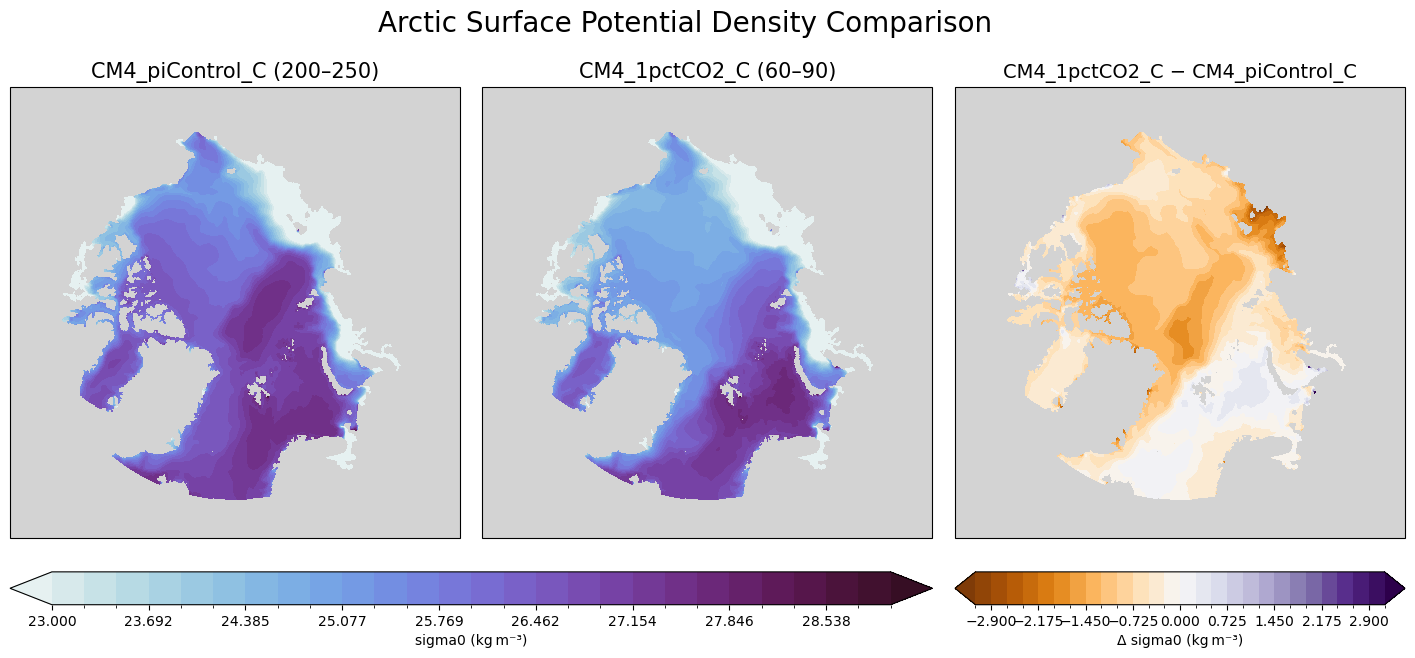

In [34]:
basin_code_list = [["Arctic Ocean",4]]
lstr = 'sigma0'
pot_density = lstr
raw_dsets = realm_list()

for region_i, basin_integer in basin_code_list:
    dsets_copy, basincodes_arr = groupCoordinateChange(raw_dsets, groups, basin_integer=basin_integer)
    spd_list = potential_density_masked(pot_density, dsets_copy, basincodes_arr, basin_integer)
    plot_density(pot_density, spd_list)